In [1]:
from pope_model_api import *
from utils.draw_utils import draw_bbox_3d, draw_axis
%matplotlib inline
import matplotlib.pyplot as plt

layer_name: ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross']
layer_name: ['self', 'cross']


2023-12-21 13:41:46.208 | INFO     | pope_model_api:<module>:182 - load Matcher successfully


In [2]:
ckpt, model_type = get_model_info("h")
sam = sam_model_registry[model_type](checkpoint=ckpt)
DEVICE = "cuda"
sam.to(device=DEVICE)
MASK_GEN = SamAutomaticMaskGenerator(sam)
logger.info(f"load SAM model from {ckpt}")
crop_tool = CropImage()
dinov2_model = load_dinov2_model()
dinov2_model.to("cuda:0")

2023-12-21 13:41:55.179 | INFO     | __main__:<module>:6 - load SAM model from weights/sam_vit_h_4b8939.pth


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): DropPath()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): DropPath()
    )
  )
  (n

In [392]:
# lm_test_all/test/000001/48
prompt_filename = os.path.join("data/demos/inputs", "prompt.png")
prompt_filename = "data/LM_dataset/0801-lm1-others/lm1-3/color/458.png"
# prompt_filename = "data/onepose/0409-aptamil-box/aptamil-2/color/606.png"
# prompt_filename = "data/oneposeplusplus/0712-insta-others/insta-2/color/1628.png"
# lm_test_all/test/000001/4
target_filename = os.path.join("data/demos/inputs", "target.png")
target_filename = "data/LM_dataset/0801-lm1-others/lm1-3/color_full/600.png"
# target_filename = "data/onepose/0409-aptamil-box/aptamil-2/color/547.png"
# target_filename = "data/oneposeplusplus/0712-insta-others/insta-2/color/210.png"
prompt_filename, target_filename

('data/LM_dataset/0801-lm1-others/lm1-3/color/458.png',
 'data/LM_dataset/0801-lm1-others/lm1-3/color_full/600.png')

In [393]:
# 相机内参矩阵
# K0是prompt的相机内参矩阵
K0 = np.array([
    [2.442288639999999759e+03, 0.000000000000000000e+00, 4.491140266666666321e+02],
    [-2.776560722850263257e-13, 2.447233834666666553e+03, -1.107243093333333093e+02],
    [0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]
])
K0 = np.loadtxt("data/LM_dataset/0801-lm1-others/lm1-3/intrin_ba/458.txt")
# K0 = np.loadtxt("data/onepose/0409-aptamil-box/aptamil-2/intrin_ba/606.txt")
# K0 = np.loadtxt("data/oneposeplusplus/0712-insta-others/insta-2/intrin_ba/1628.txt")

# K1是target的相机内参矩阵
K1 = np.array([
    [5.724113999999999578e+02, 0.000000000000000000e+00, 3.252610999999999990e+02],
    [0.000000000000000000e+00, 5.735704299999999876e+02, 2.420489900000000034e+02],
    [0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]
])
K1 = np.loadtxt("data/LM_dataset/0801-lm1-others/lm1-3/intrin/600.txt")
# K1 = np.loadtxt("data/onepose/0409-aptamil-box/aptamil-2/intrin_ba/547.txt")
# K1 = np.loadtxt("data/oneposeplusplus/0712-insta-others/insta-2/intrin_ba/210.txt")

# 这里是Linemod中的第一类物体
# 在lm_models/models/models_info.json中可以找到下面的坐标信息
# lm_models/models/obj_000001.ply是这个模型的点云
x, y, z = 3.793429999999999719e-02, 3.879959999999999659e-02, 4.588450000000000167e-02
_3d_bbox = np.array([
    [-x, -y, -z],
    [-x, -y, z],
    [-x, y, z],
    [-x, y, -z],
    [x, -y, -z],
    [x, -y, z],
    [x, y, z],
    [x, y, -z]
])
_3d_bbox = np.loadtxt("data/LM_dataset/0801-lm1-others/box3d_corners.txt")
# _3d_bbox = np.loadtxt("data/onepose/0409-aptamil-box/box3d_corners.txt")
# _3d_bbox = np.loadtxt("data/oneposeplusplus/0712-insta-others/box3d_corners.txt")

In [394]:
# lm_test_all/test/000001/48
prompt_pose = np.loadtxt(os.path.join("data/demos/inputs", "prompt.txt"))
prompt_pose = np.loadtxt("data/LM_dataset/0801-lm1-others/lm1-3/poses_ba/458.txt")
# prompt_pose = np.loadtxt("data/onepose/0409-aptamil-box/aptamil-2/poses_ba/606.txt")
# prompt_pose = np.loadtxt("data/oneposeplusplus/0712-insta-others/insta-2/poses_ba/1628.txt")
# lm_test_all/test/000001/4
target_pose = np.loadtxt(os.path.join("data/demos/inputs", "target.txt"))
target_pose = np.loadtxt("data/LM_dataset/0801-lm1-others/lm1-3/poses_ba/600.txt")
# target_pose = np.loadtxt("data/onepose/0409-aptamil-box/aptamil-2/poses_ba/547.txt")
# target_pose = np.loadtxt("data/oneposeplusplus/0712-insta-others/insta-2/poses_ba/210.txt")

In [395]:
# 读prompt图片，读出来的是ndarray
prompt_image = cv2.imread(prompt_filename)
# 复制一份prompt图片，但实际上没有在原代码中用到
prompt_image_copy = prompt_image.copy()
# 这里将图片进行预处理，将cv2.imread读出来的ndarray转成torch tensor
ref_torch_image = set_torch_image(prompt_image, center_crop=True)
# 使用dinov2_model对prompt_image进行前向传播
ref_fea = get_cls_token_torch(dinov2_model, ref_torch_image)
# 读target图片，读出来的是ndarray
target_image = cv2.imread(target_filename)

In [396]:
ref_fea.shape

torch.Size([1, 384])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


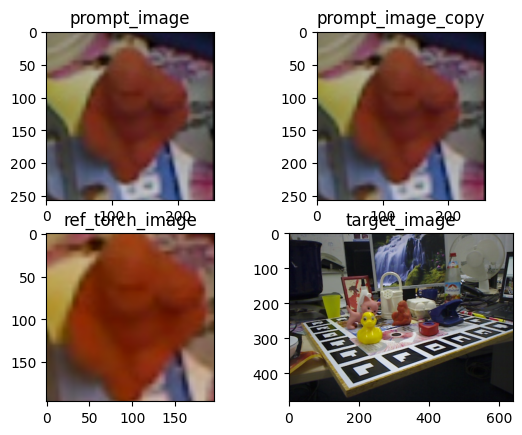

In [397]:
# 打印prompt_image，prompt_image_copy，反归一化后的ref_torch_image和target_image
plt.figure()

plt.subplot(221)
plt.title("prompt_image")
plt.imshow(cv2.cvtColor(prompt_image, cv2.COLOR_BGR2RGB))

plt.subplot(222)
plt.title("prompt_image_copy")
plt.imshow(cv2.cvtColor(prompt_image_copy, cv2.COLOR_BGR2RGB))

ref_torch_image_mean = np.array([0.485, 0.456, 0.406])
ref_torch_image_std = np.array([0.229, 0.224, 0.225])
plt.subplot(223)
plt.title("ref_torch_image")
plt.imshow(cv2.cvtColor(ref_torch_image[0].permute(1, 2, 0).cpu().numpy(), cv2.COLOR_BGR2RGB) * ref_torch_image_std + ref_torch_image_mean)

plt.subplot(224)
plt.title("target_image")
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))

plt.show()

In [398]:
image_h, image_w, _ = target_image.shape
t1 = time.time()
masks = MASK_GEN.generate(target_image)
t2 = time.time()
similarity_score, top_images = np.array([0, 0, 0], np.float32) , [[], [], []]
t3 = time.time()
compact_percent = 0.3

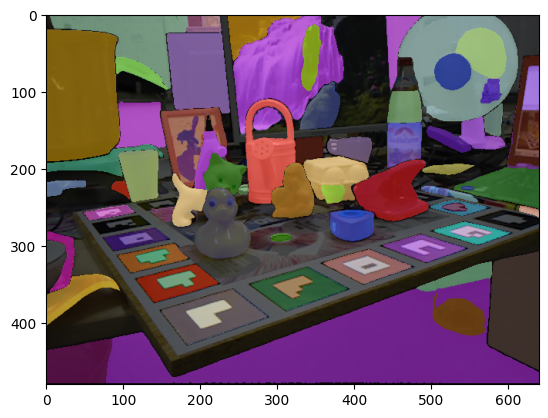

In [399]:
def render_mask(masks):
    if len(masks) == 0:
        return None
    res = np.zeros([masks[0]["segmentation"].shape[0], masks[0]["segmentation"].shape[1], 3])
    sorted_masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    for mask in sorted_masks:
        m = mask["segmentation"]
        res[:, :, 0][m] = np.random.randint(0, 255)
        res[:, :, 1][m] = np.random.randint(0, 255)
        res[:, :, 2][m] = np.random.randint(0, 255)
    res = res.astype(np.uint8)
    return res

color_mask = render_mask(masks)
thres = 0.40
render_img = (target_image * thres + color_mask * (1 - thres)).astype(np.uint8)
plt.figure()
plt.imshow(cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB))
plt.show()

In [400]:
target_image.shape, len(masks), type(masks[1]), [key for key in masks[1].keys()]

((480, 640, 3),
 75,
 dict,
 ['segmentation',
  'area',
  'bbox',
  'predicted_iou',
  'point_coords',
  'stability_score',
  'crop_box'])

In [401]:
masks[1]['segmentation'].shape, masks[1]['area'], masks[1]['bbox'], masks[1]['predicted_iou']

((480, 640), 3794, [266, 328, 124, 56], 1.0131162405014038)

In [402]:
masks[1]['point_coords'], masks[1]['stability_score'], masks[1]['crop_box']

([[340.0, 345.0]], 0.9832504391670227, [0, 0, 640, 480])

In [403]:
object_mask = np.expand_dims(masks[1]["segmentation"], -1)
x0, y0, w, h = masks[1]["bbox"]
x1, y1 = x0 + w, y0 + h
x0 -= int(w * compact_percent)
y0 -= int(h * compact_percent)
x1 += int(w * compact_percent)
y1 += int(h * compact_percent)
box = np.array([x0, y0, x1, y1])
resize_shape = np.array([y1 - y0, x1 - x0])
K_crop, K_crop_homo = get_K_crop_resize(box, K1, resize_shape)
image_crop, _ = get_image_crop_resize(target_image, box, resize_shape)
# object_mask, _ = get_image_crop_resize(object_mask, box, resize_shape)
box_new = np.array([0, 0, x1 - x0, y1 - y0])

In [404]:
object_mask.shape, x0, y0, x1, y1, box, resize_shape, K_crop.shape, K_crop_homo.shape, image_crop.shape, box_new

((480, 640, 1),
 229,
 312,
 427,
 400,
 array([229, 312, 427, 400]),
 array([ 88, 198]),
 (3, 3),
 (3, 4),
 (88, 198, 3),
 array([  0,   0, 198,  88]))

(480, 640, 3)


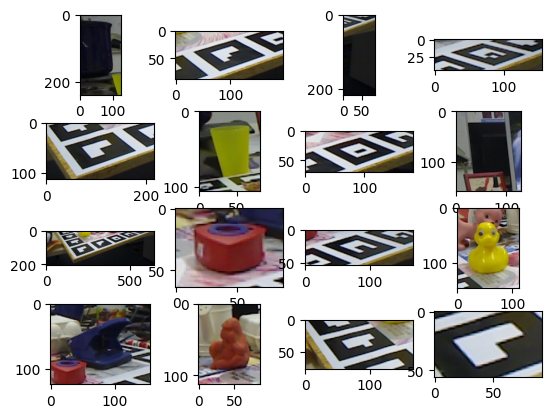

In [405]:
print(target_image.shape)
plt.figure()
for i in range(16 if len(masks) > 16 else len(masks)):
    x0, y0, w, h = masks[i]["bbox"]
    x1, y1 = x0 + w, y0 + h
    x0 -= int(w * compact_percent)
    y0 -= int(h * compact_percent)
    x1 += int(w * compact_percent)
    y1 += int(h * compact_percent)
    plt.subplot(4, 4, i+1)
    plt.imshow(cv2.cvtColor(target_image[y0 if y0 > 0 else 0:y1, x0 if x0 > 0 else 0:x1], cv2.COLOR_BGR2RGB))
plt.show()

In [406]:
resize_shape = np.array([256, 256])
K_crop, K_crop_homo = get_K_crop_resize(box_new, K_crop, resize_shape)
image_crop, _ = get_image_crop_resize(image_crop, box_new, resize_shape)
crop_tensor = set_torch_image(image_crop, center_crop=True)
with torch.no_grad():
    fea = get_cls_token_torch(dinov2_model, crop_tensor)
# 从prompt_image中抽取ref_fea
# 从target_image中抽取fea
score = F.cosine_similarity(ref_fea, fea, dim=1, eps=1e-8)
if (score.item() > similarity_score).any():
    test_image_crop = image_crop
    test_K_crop = K_crop
    test_box = box
    min_idx = np.argmin(similarity_score)
    similarity_score[min_idx] = score.item()
    top_images[min_idx] = masks[0].copy()

In [407]:
resize_shape, K_crop, K_crop_homo

(array([256, 256]),
 array([[ 7.40087467e+02,  0.00000000e+00,  1.24458796e+02],
        [ 1.28259457e-13,  7.41586011e+02, -1.93305988e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 7.40087467e+02,  0.00000000e+00,  1.24458796e+02,
          0.00000000e+00],
        [ 1.28259457e-13,  7.41586011e+02, -1.93305988e+01,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00]]))

In [408]:
for _, mask in enumerate(masks):
    object_mask = np.expand_dims(mask["segmentation"], -1)
    x0, y0, w, h = mask["bbox"]
    x1, y1 = x0 + w, y0 + h
    x0 -= int(w * compact_percent)
    y0 -= int(h * compact_percent)
    x1 += int(w * compact_percent)
    y1 += int(h * compact_percent)
    box = np.array([x0, y0, x1, y1])
    resize_shape = np.array([y1 - y0, x1 - x0])
    K_crop, K_crop_homo = get_K_crop_resize(box, K1, resize_shape)
    image_crop, _ = get_image_crop_resize(target_image, box, resize_shape)
    # object_mask, _ = get_image_crop_resize(object_mask, box, resize_shape)
    box_new = np.array([0, 0, x1 - x0, y1 - y0])
    resize_shape = np.array([256, 256])
    K_crop, K_crop_homo = get_K_crop_resize(box_new, K_crop, resize_shape)
    image_crop, _ = get_image_crop_resize(image_crop, box_new, resize_shape)
    crop_tensor = set_torch_image(image_crop, center_crop=True)
    with torch.no_grad():
        fea = get_cls_token_torch(dinov2_model, crop_tensor)
    score = F.cosine_similarity(ref_fea, fea, dim=1, eps=1e-8)
    if (score.item() > similarity_score).any():
        mask["crop_image"] = image_crop
        mask["K"] = K_crop
        mask["bbox"] = box
        min_idx = np.argmin(similarity_score)
        similarity_score[min_idx] = score.item()
        top_images[min_idx] = mask.copy()

In [409]:
prompt_image = cv2.cvtColor(prompt_image, cv2.COLOR_BGR2GRAY)
prompt_image = torch.from_numpy(prompt_image).float()[None] / 255.
prompt_image = prompt_image.unsqueeze(0).cuda()

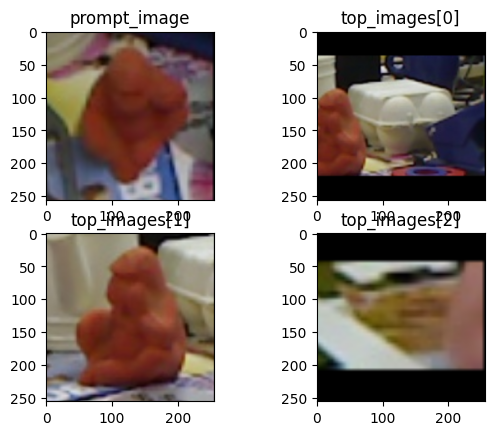

In [410]:
plt.figure()
plt.subplot(221)
plt.title("prompt_image")
plt.imshow(cv2.cvtColor(prompt_image_copy, cv2.COLOR_BGR2RGB))
for i in range(len(top_images)):
    plt.subplot(221+i+1)
    plt.title(f"top_images[{i}]")
    plt.imshow(cv2.cvtColor(top_images[i]["crop_image"], cv2.COLOR_BGR2RGB))
plt.show()

In [411]:
matching_score =  [[0] for _ in range(len(top_images))]
for top_idx in range(len(top_images)):
    img1 = cv2.cvtColor(top_images[top_idx]["crop_image"], cv2.COLOR_BGR2GRAY)
    img1 = torch.from_numpy(img1).float()[None] / 255.
    img1 = img1.unsqueeze(0).cuda()
    batch = {'image0':prompt_image, 'image1':img1}
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        confidences = batch["mconf"].cpu().numpy()
    conf_mask = np.where(confidences > 0.9)
    matching_score[top_idx] = conf_mask[0].shape[0]
    top_images[top_idx]["mkpts0"] = mkpts0
    top_images[top_idx]["mkpts1"] = mkpts1
    top_images[top_idx]["mconf"] = confidences

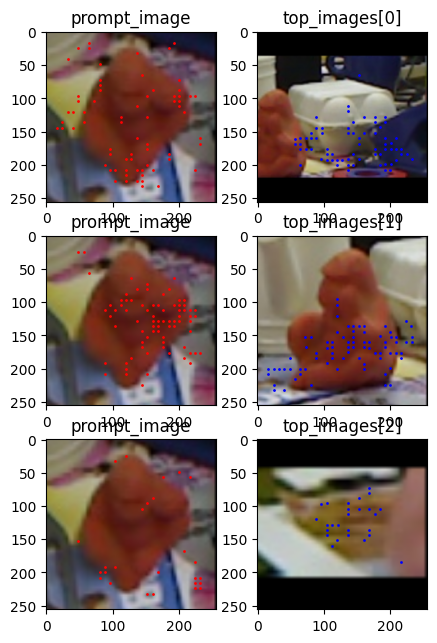

In [412]:
plt.figure(figsize=(5, 7.5))
for i in range(len(top_images)):
    plt.subplot(321+i+i)
    plt.title("prompt_image")
    plt.imshow(cv2.cvtColor(prompt_image_copy, cv2.COLOR_BGR2RGB))
    plt.scatter(top_images[i]["mkpts0"][:, 0], top_images[i]["mkpts0"][:, 1], c="r", s=1)
for i in range(len(top_images)):
    plt.subplot(321+i+i+1)
    plt.title(f"top_images[{i}]")
    plt.imshow(cv2.cvtColor(top_images[i]["crop_image"], cv2.COLOR_BGR2RGB))
    plt.scatter(top_images[i]["mkpts1"][:, 0], top_images[i]["mkpts1"][:, 1], c="b", s=1)
plt.show()

# for i in range(len(top_images)):
#     print(f"top_images[{i}]['mkpts0'].shape: {top_images[i]['mkpts0'].shape}")
#     print(f"top_images[{i}]['mkpts1'].shape: {top_images[i]['mkpts1'].shape}")
#     print(f"top_images[{i}]['mconf'].shape: {top_images[i]['mconf'].shape}")

In [413]:
matching_score

[15, 14, 6]

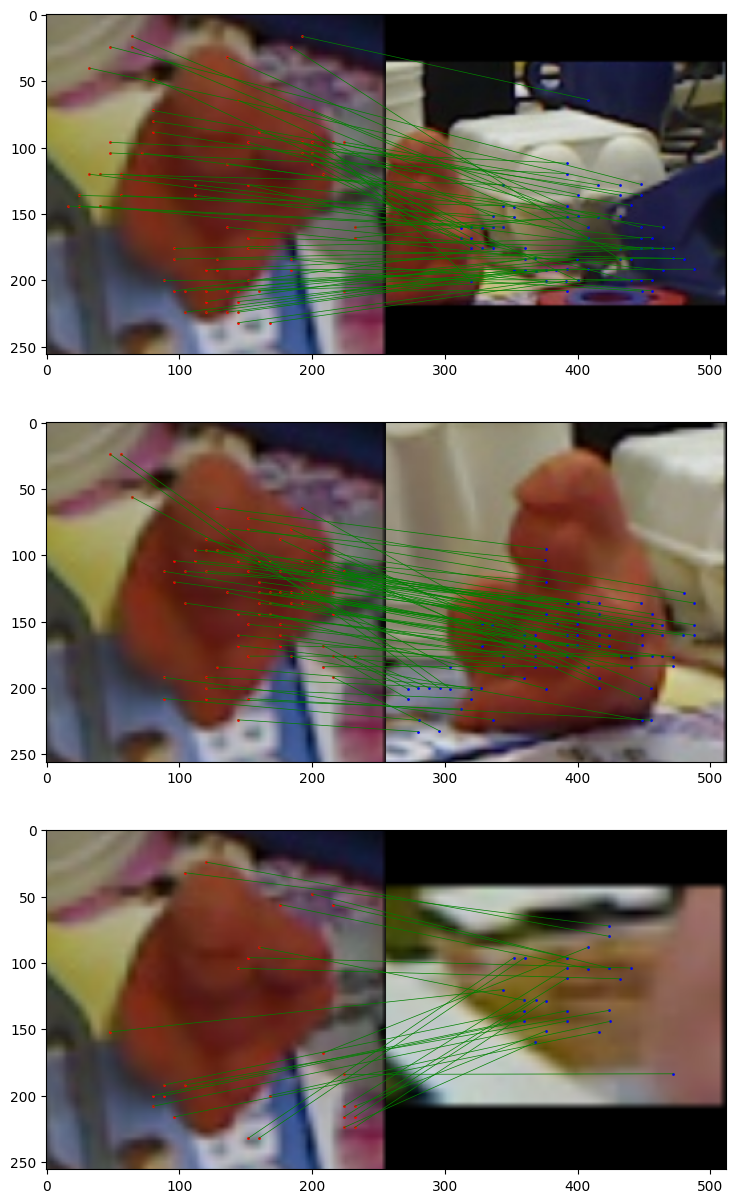

In [414]:
plt.figure(figsize=(10, 15))
for i in range(len(top_images)):
    plt.subplot(311+i)
    plt.imshow(cv2.cvtColor(np.concatenate((prompt_image_copy, top_images[i]["crop_image"]), axis=1), cv2.COLOR_BGR2RGB))
    plt.scatter(top_images[i]["mkpts0"][:, 0], top_images[i]["mkpts0"][:, 1], c="r", s=1)
    plt.scatter(top_images[i]["mkpts1"][:, 0] + 256, top_images[i]["mkpts1"][:, 1], c="b", s=1)
    for j in range(top_images[i]["mkpts0"].shape[0]):
        plt.plot([top_images[i]["mkpts0"][j, 0], top_images[i]["mkpts1"][j, 0] + 256], [top_images[i]["mkpts0"][j, 1], top_images[i]["mkpts1"][j, 1]], c="g", linewidth=0.5)
plt.show()

In [415]:
max_match_idx = np.argmax(matching_score)
pre_bbox  = top_images[max_match_idx]["bbox"]
mkpts0 = top_images[max_match_idx]["mkpts0"]
mkpts1 = top_images[max_match_idx]["mkpts1"]
pre_K = top_images[max_match_idx]["K"]

In [416]:
pre_bbox, type(mkpts0), mkpts0.shape, mkpts1.shape, pre_K

(array([309, 166, 443, 262]),
 numpy.ndarray,
 (68, 2),
 (68, 2),
 array([[1.09356208e+03, 0.00000000e+00, 3.10659821e+01],
        [8.26619777e-14, 1.09577634e+03, 1.81586130e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

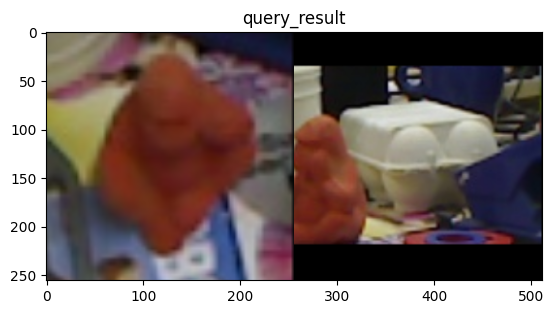

In [417]:
crop_image = cv2.resize(top_images[np.argmax(matching_score)]["crop_image"], (256, 256))
que_image = cv2.resize(prompt_image_copy, (256, 256))
segment_mask = (255 * top_images[np.argmax(matching_score)]["segmentation"]).astype(np.uint8)
stack_result_image = np.hstack((que_image, crop_image))
# cv2.imwrite("query_result.png", stack_result_image)
plt.figure()
plt.title("query_result")
plt.imshow(cv2.cvtColor(stack_result_image, cv2.COLOR_BGR2RGB))
plt.show()
# 估计出了两个小图之间的旋转和位移
R, t, inliers = estimate_pose(mkpts0, mkpts1, K0, pre_K, 0.5, 0.99)

In [418]:
prompt_pose, target_pose

(array([[ 0.24592599,  0.96925801, -0.00773198, -0.13120541],
        [ 0.73461801, -0.19158401, -0.65087098,  0.12445584],
        [-0.63234299,  0.154386  , -0.75914901,  0.99928653]]),
 array([[-0.83515602,  0.54852402, -0.0404445 , -0.00621357],
        [ 0.161466  ,  0.174217  , -0.97137898, -0.01807954],
        [-0.525778  , -0.81778401, -0.23406599,  0.738258  ]]))

In [419]:
predict_pose = np.zeros((3, 4)).astype(np.float32)
# 将相对旋转作用到prompt_pose的旋转上
predict_pose[:3, :3] = np.matmul(R, prompt_pose[:3, :3])
our_predict_pose = predict_pose[:3, :3].copy()
# target_pose中的位移不会改变，直接赋值给predict_pose
predict_pose[:3, 3] = target_pose[:3, 3]
# 将3Dbbox根据predict_pose和target视角下的内参投影到2D平面上
pre_bbox_pts_3d, _ = project_points(_3d_bbox, predict_pose[:3, :4], K1)
pre_bbox_pts_3d = pre_bbox_pts_3d.astype(np.int32)

pre_bbox_pts_3d_gt, _ = project_points(_3d_bbox, target_pose[:3, :4], K1)
pre_bbox_pts_3d_gt = pre_bbox_pts_3d_gt.astype(np.int32)

In [420]:
pre_bbox_pts_3d, pre_bbox_pts_3d_gt

(array([[306, 196],
        [272, 209],
        [285, 266],
        [321, 260],
        [357, 187],
        [319, 200],
        [331, 254],
        [371, 247]], dtype=int32),
 array([[329, 251],
        [326, 186],
        [361, 192],
        [363, 263],
        [282, 261],
        [278, 192],
        [309, 199],
        [313, 274]], dtype=int32))

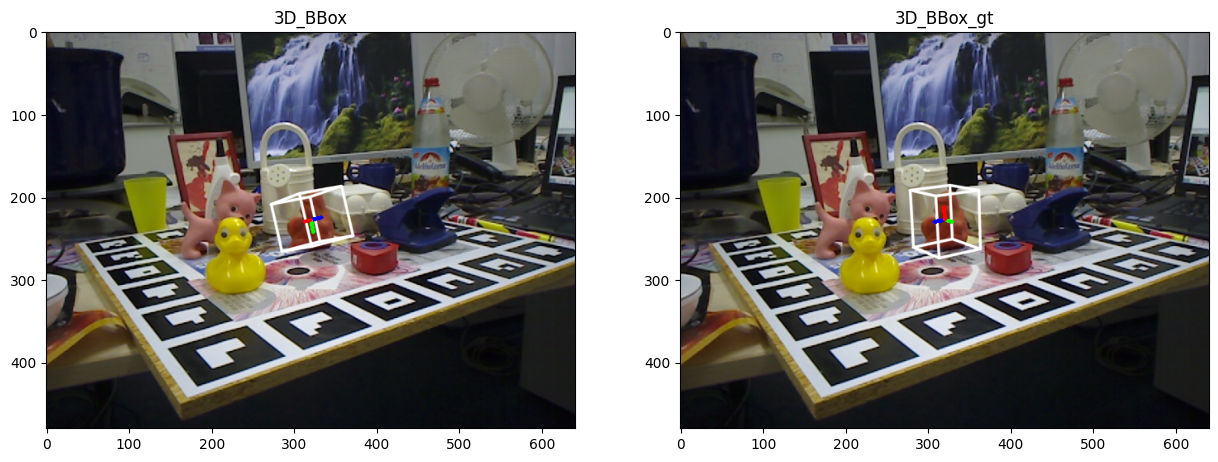

In [421]:
target_image_copy = target_image.copy()
our_bbox_img = draw_bbox_3d(target_image, pre_bbox_pts_3d, (255, 255, 255))
our_bbox_img = draw_axis(our_bbox_img, predict_pose[:3, :3], predict_pose[:3, 3], K1)
our_bbox_img_gt = draw_bbox_3d(target_image_copy, pre_bbox_pts_3d_gt, (255, 255, 255))
our_bbox_img_gt = draw_axis(our_bbox_img_gt, target_pose[:3, :3], target_pose[:3, 3], K1)
# cv2.imwrite(f"3D_BBox.png", our_bbox_img)
plt.figure(figsize=(15, 7.5))

plt.subplot(121)
plt.title("3D_BBox")
plt.imshow(cv2.cvtColor(our_bbox_img, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title("3D_BBox_gt")
plt.imshow(cv2.cvtColor(our_bbox_img_gt, cv2.COLOR_BGR2RGB))

plt.show()